In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt

data = pd.read_csv('C:/Users/Drew/Downloads/jj.csv')
data.describe()

,data
count,84.000000
mean,4.799762
std,4.309991
min,0.440000
25%,1.247500
50%,3.510000
75%,7.132500
max,16.200000


In [49]:
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


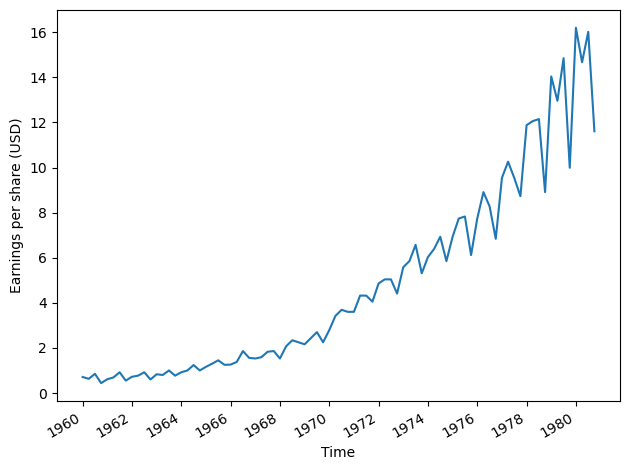

In [2]:
fig, ax = pt.subplots()

ax.plot(data['data'])
ax.set_xlabel('Time')
ax.set_ylabel('Earnings per share (USD)')
pt.xticks(np.arange(0, 84, 8), np.arange(1960, 1982, 2))
fig.autofmt_xdate()
pt.tight_layout()

# Autoregressive Integrated Moving Average Model

Autoregressive Integrated Moving Average Model (ARIMA) process is the combination of AR(p) and MA(q) processes, but in terms of the differenced series. It is denoted as ARIMA (p,d,q), where p is the order of AR(p) process, d is the order of integration, and q is the order of the MA(q) process. 

Integration (d) is the reverse of differencing, and the order of integration d is equal to the number of times the series has been differenced to be rendered stationary. ϵt





The ARIMA model is very identical to the ARMA model but there is a few aspect are different from each other. In the ARMA model, we can only forecast on a stationary time series data, in other words differenced data. However, in ARIMA model, we do not need the time series data to be stationary to forecast. We can just apply the ARIMA model to forecast on a non-stationary time series data (non-differenced  Again, in short, ARIMA model is simply an ARMA model that can be applied on non-stationary time series. Whereas ARMA model requires the series to be stationary before fitting an ARMA(p,q) model.data).

# General Modeling Procedure

Just like the ARMA(p,q) model, we are adding an additional step before listing the values of p and q. We are adding the step "Set d equal to the number of times the series was differenced". Also, during fitting all possible combinations step, we include integration(d) as well.

In [3]:
from statsmodels.tsa.stattools import adfuller

ADF_results = adfuller(data['data'])
print(f' ADF Statistic: {ADF_results[0]}')
print(f' P-value: {ADF_results[1]}')

 ADF Statistic: 2.742016573457468
 P-value: 1.0


Due to the ADF statistics, we cannot reject the null hypothesis, hence, the time series data is not stationary. We need to determine how many times the series must be differenced to become stationary. This will then set the order of integration d, We can apply a first-order differencing and test for stationarity.

In [4]:
eps_diff = np.diff(data['data'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f' ADF Statistics: {ad_fuller_result[0]}')
print(f' P-value: {ad_fuller_result[1]}')

 ADF Statistics: -0.407409763638043
 P-value: 0.9088542416911309


According to the ADF statistics on the first order differencing, we still cannot reject the null hypothesis because the p-value is greater than 0.05 and a large negative ADF statistic. Thus, after first-order differencing our time series data is still non stationary. So, we will then try to use second-order differencing to make our data stationary, which means d = 2.

In [5]:
eps_diff = np.diff(data['data'], n=2)
ad_fuller_result = adfuller(eps_diff)
print(f' ADF Statistics: {ad_fuller_result[0]}')
print(f' P-value: {ad_fuller_result[1]}')

 ADF Statistics: -3.5851628747931517
 P-value: 0.006051099869603741


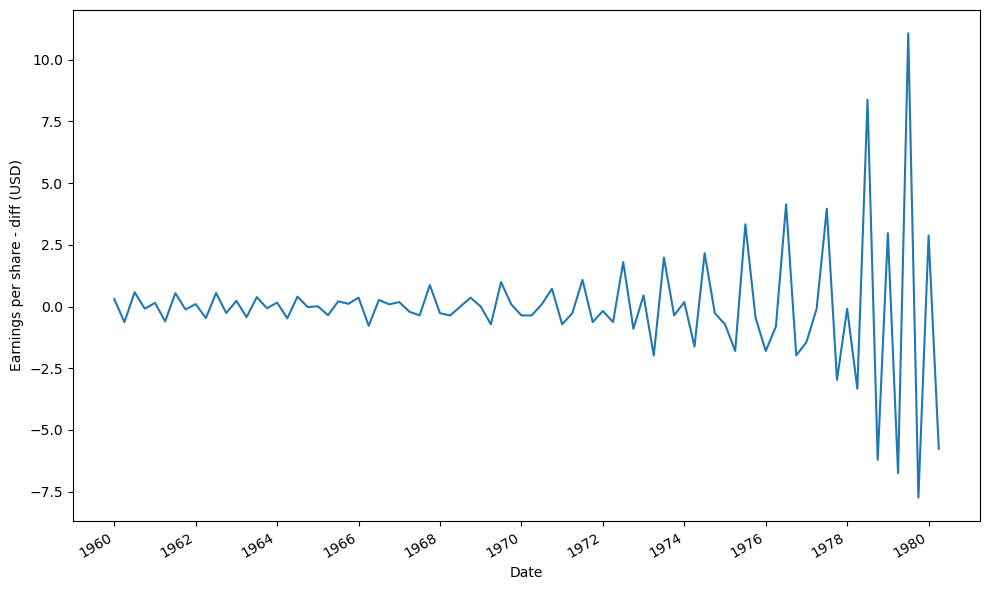

In [20]:
fig , ax = pt.subplots(figsize=(10,6))

ax.plot(data['date'][2:], eps_diff) #Start index at 2 because of second-order differencing
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

pt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
pt.tight_layout()

Now that we know that the second-order differencing rejects the null hypothesis with a p-value less than 0.05 and a large negative value. Which means that our data will be stationary with second-order differencing.

# Splitting the Dataset

Before we move on to fitting different combinations of ARIMA(p,d,q) models, we must separate our data into train and test sets.

In [6]:
train = data[:-4]
test = data[-4:]

print(len(train))
print(len(test))

80
4


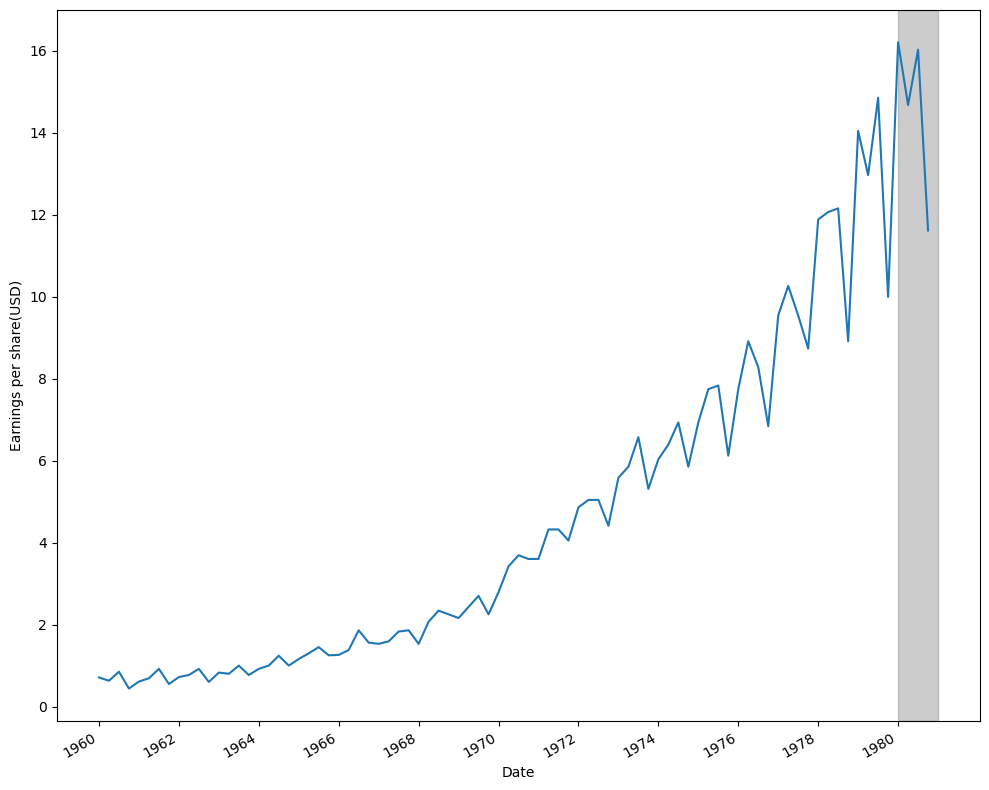

In [8]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(data['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share(USD)')
ax.axvspan(80,84, color="#808080", alpha=0.4)
pt.xticks(np.arange(0,81,8), [1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])
fig.autofmt_xdate()
pt.tight_layout()

# Function to fit all unique ARIMA(p,d,q) models

Just the same as the one we always use for ARMA, just adding in the order d parameter.

In [11]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = [] #initialize an empty list to store results
    for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.
        try: 
            #Fit an ARIMA(p,d,q) model using the SARIMAX function. 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic #Calculate the model AIC
        results.append([order,aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sorting the results from ascending order. The lower the AIC the better.
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values for q from 0 inclusively to 4 exclusively, with steps of 1
d = 2 #set d to 2 because the series needed to be differenced twice to become stationary.

order_list = list(product(ps,qs)) #Generate a list containing all unique combinations of (p,q)

In [15]:
train = data.data[:-4]
result_data = optimize_ARIMA(train, order_list, d)
result_data

C:\Users\Drew\AppData\Local\Temp\ipykernel_8188\903790325.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace

,"(p,q)",AIC
0,"(3, 3)",115.273665
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430678
4,"(0, 3)",194.654716
5,"(0, 2)",209.274515
6,"(2, 3)",220.666885
7,"(1, 3)",228.267839
8,"(1, 2)",228.935907
9,"(2, 2)",229.974675


So, the best model is ARIMA (3,2,3) with the lowest AIC.

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


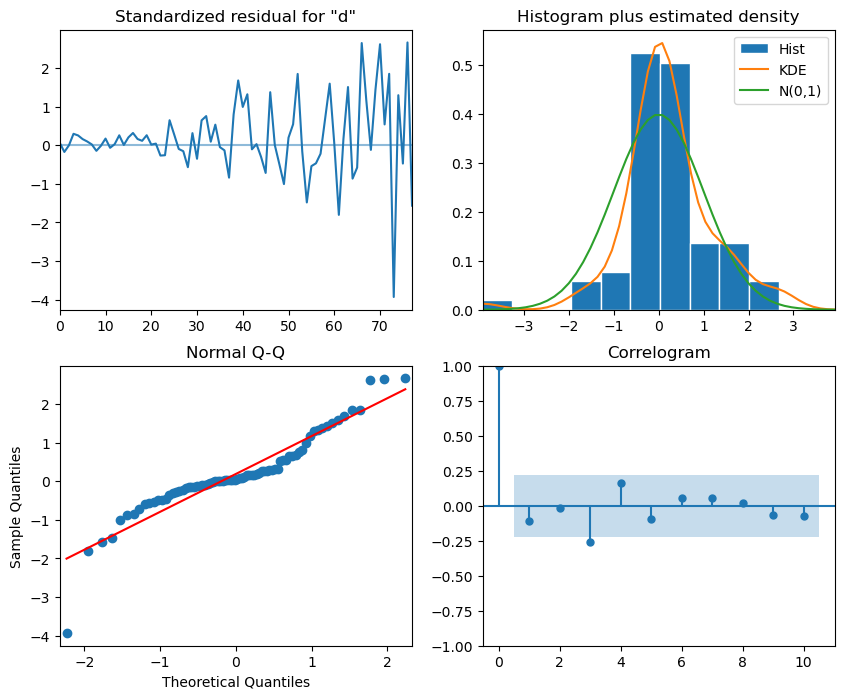

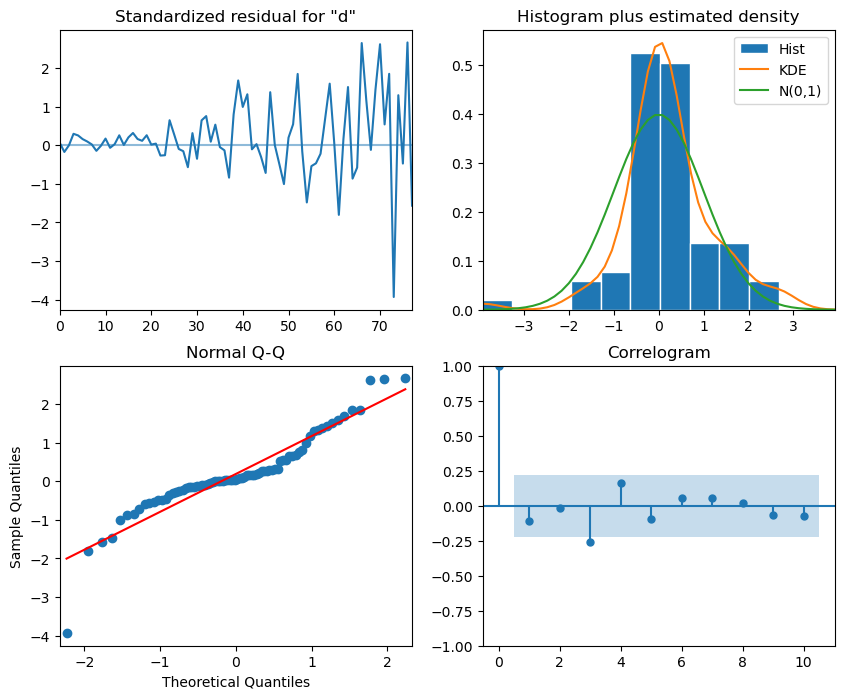

In [21]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8))

# IMPORTANT
The top left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is discrepancy in comparison to white noise. The top right is the distribution of the residuals. We can see it fairly close to the normal distribution. The Q-Q plot leads us to the same conclusion as it displays a line that is fairly straight, meaning that the residual's distribution is close to a normal distribution. Lastly, the correlogram exhibits no significant autocorrelation coefficients after lag 0, just like white noise. In conclusion, these plots tells us that our residuals are close to white noise, which is a good sign, as it means that the model's errors are random. 

This is because when the residuals closely resemble white noise, it indicates that the model has effectively captured the underlying pattern and structures in the data, leaving only random, uncorrelated noise. When the residuals meet these criteria and closely resemble white noise, it indicates that the model has adequately explained the variability in the data, and the remaining difference are due to random noise.

Residuals are the difference of the actual values and predicted values. These residuals represent the unexplained variability in the data after accounting for the model's predictions. The purpose of the residual analysis is to evaluate whether the model adequately captures the underlying patterns and structures in the data. By comparing it to the white noise, which serves as a baseline, we can assess how well the model explains the variability in the data. 

If the residuals closely resemble white noise, it indicates that the model has effectively captured the systematic patterns in the data, leaving behind only random, uncorrelated noise. In this case, we have confidence that the model is suitable for forecasting future values. On the other hand, if the residuals exhibit systematic patterns, correlations, or non-constant variance, it suggests that the model may not adequately explain all the variability in the data. In such cases, further investigation and possibly model refinement may be necessary to improve the model's performance. 

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

residuals = model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(0,11,1))
print(pvalue)

      lb_stat  lb_pvalue
0   11.097156        NaN
1    1.583947   0.208193
2    1.585094   0.452690
3    7.242882   0.064546
4    9.166799   0.057063
5    9.780272   0.081706
6   10.009054   0.124271
7   10.258275   0.174404
8   10.294646   0.244952
9   10.636937   0.301418
10  11.097156   0.349999


Null Hypothesis = represents statement that has no effect, no relationship, no difference etc.

The ljungbox statistics return all 10 lags of p-value and all of them are greater than 0.05. Thus, we cannot reject the null-hypothesis and conclude that the residuals are not correlated. 

# Forecasting

In [38]:
test = data.iloc[-4:] 
#The naive seasonal forecast is implemented by selecting the quarterly EPS reported in 1979 using the same values as a forecast for year 1980
test['naive_seasonal'] = data['data'].iloc[76:80].values 
test.head()

C:\Users\Drew\AppData\Local\Temp\ipykernel_8188\4149435976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = data['data'].iloc[76:80].values


,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [43]:
ARIMA_pred = model_fit.get_prediction(80,83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred #Assign the forecast to the ARIMA_pred column
test.head()

C:\Users\Drew\AppData\Local\Temp\ipykernel_8188\649495835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred #Assign the forecast to the ARIMA_pred column


,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858615
81,1980-04-01,14.67,12.96,14.380478
82,1980-07-02,16.02,14.85,16.371732
83,1980-10-01,11.61,9.99,11.683178


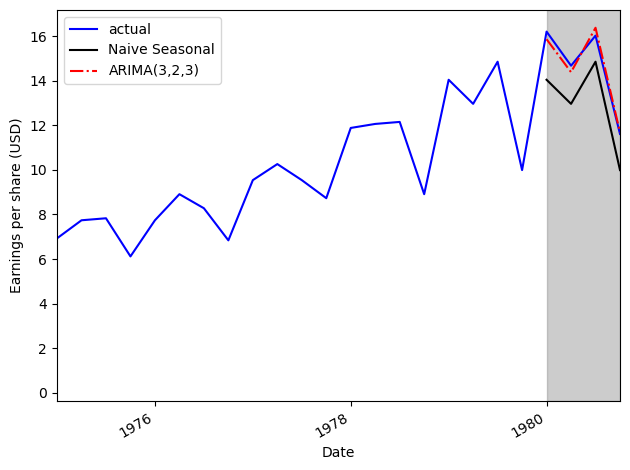

In [44]:
fig, ax = pt.subplots()

ax.plot(data['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'k-', label='Naive Seasonal')
ax.plot(test['ARIMA_pred'], 'r-.', label='ARIMA(3,2,3)')
ax.legend(loc=2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80,83, color="#808080", alpha=0.4)
pt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)
fig.autofmt_xdate()
pt.tight_layout()

# Mean absolute percentage error function 

In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7266897355162851


In [51]:
#Alternatively we can use function from the sklearn.metrics as well
#However, we must multiply the result by 100 to obtain the percentage value.
from sklearn.metrics import mean_absolute_percentage_error

alternative_mape_naive = mean_absolute_percentage_error(test['data'], test['naive_seasonal'])
alternative_mape_ARIMA = mean_absolute_percentage_error(test['data'], test['ARIMA_pred'])

print(alternative_mape_naive, alternative_mape_ARIMA)

0.11561658552433654 0.01726689735516285


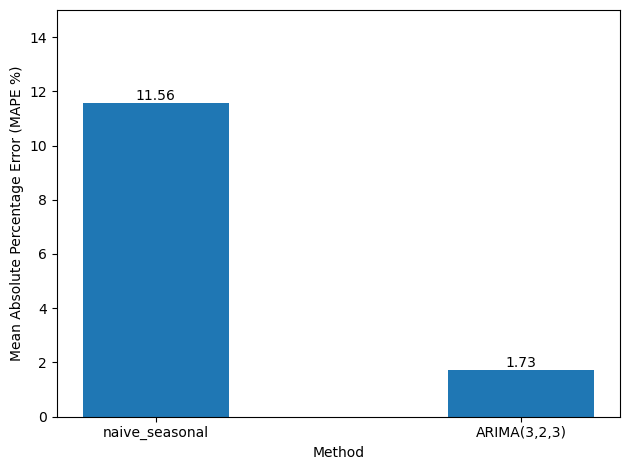

In [47]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

fig, ax = pt.subplots()

x = ['naive_seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x,y, width=0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Absolute Percentage Error (MAPE %)')
ax.set_ylim(0,15)

for index, value in enumerate(y):
    pt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

pt.tight_layout()

Based on the MAPE, we can see that the naive seasonal forecast is 11.56% while the MAPE for ARIMA(3,2,3) is 1.73%, which roughly one fifth of the benchmark value. This means that our predictions are on average 2.19% off from the actual values.

In [48]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['data'], test['ARIMA_pred'])
print(mae)

0.2639541747705083


Alternatively, we can use the MAE to see how much of the predictions we are off from the actual value. We are about 0.26 +- off from the actual value.

# Summary

- The ARIMA(p,d,q) is the combination of the autoregressive model AR(p), the order of integration (d), and the moving average MA(q) model.
- The ARIMA model can be applied on non-stationary time series and has the added advantage of returning forecasts in the same scale as the original series.
- The order of integration d is equal to the minimum number of times a series must be differenced to become stationary.
- An ARIMA (p,d,q) model is equivalent to an ARMA(p,q) model.